In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

In [2]:
X, y = make_circles(
    n_samples = 10000,
    noise = 0.05,
    random_state = 26
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 26)

In [3]:
#visualize the data
X_train, X_train.shape

(array([[-0.86143957,  0.51365619],
        [ 0.15802293,  0.75413978],
        [ 0.10045332, -1.02042385],
        ...,
        [-0.03391136, -0.79715534],
        [-0.56320429,  0.88155148],
        [ 0.94764034,  0.31432114]]),
 (6700, 2))

In [4]:
X_test, X_test.shape

(array([[-0.78586889,  0.59082396],
        [-0.70465859,  0.34926669],
        [-0.70729354, -0.48752429],
        ...,
        [ 0.80745841, -0.69666008],
        [ 0.86903348,  0.57352575],
        [-0.62267338,  0.5105265 ]]),
 (3300, 2))

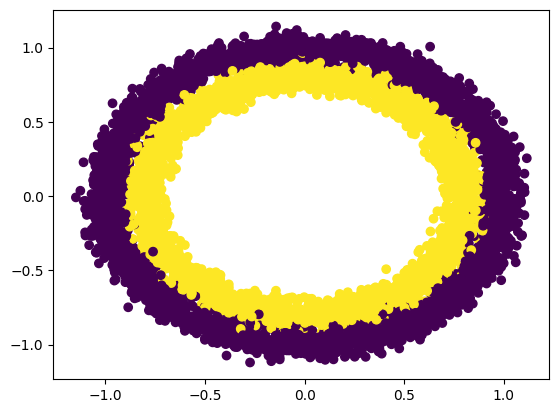

In [5]:
plt.scatter(X_train[: , 0], X_train[: , 1],c = y_train)
plt.show()

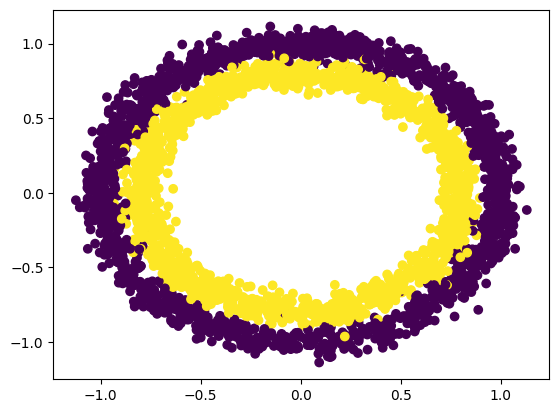

In [6]:
plt.scatter(X_test[: , 0], X_test[: , 1], c = y_test)
plt.show()

In [7]:
# Data loading
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader


class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self,index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len


batch_size = 64

train_data = Data(X_train, y_train)
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

for batch, (X, y) in enumerate(train_dataloader):
    print("batch : ", batch + 1)
    print("X_shape : ", X.shape)
    print("Y_shape : ", y.shape)
    break

batch :  1
X_shape :  torch.Size([64, 2])
Y_shape :  torch.Size([64])


In [8]:
import torch
from torch import nn
from torch import optim

input_dim = 2
hidden_dim = 10
output_dim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim , hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity = "relu")
        self.layer_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = torch.nn.functional.sigmoid(self.layer_2(x))
        return x

model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)
        

NeuralNetwork(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


In [9]:
learning_rate = 0.1
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    for X, y in train_dataloader:
        optimizer.zero_grad()

        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
        
print("Training complete")

Training complete


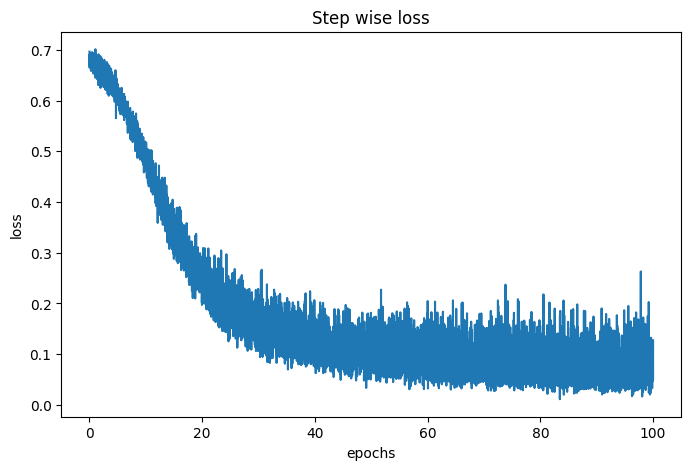

In [10]:
step = np.linspace(0, 100, 10500)

fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(step, np.array(loss_values))
plt.title("Step wise loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [11]:
import itertools

y_pred = []
y_test = []
total = 0
correct = 0

with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()

print("Accuracy : ", 100 * correct // total, "%")

Accuracy :  97 %


              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      1635
         1.0       0.97      0.98      0.98      1665

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



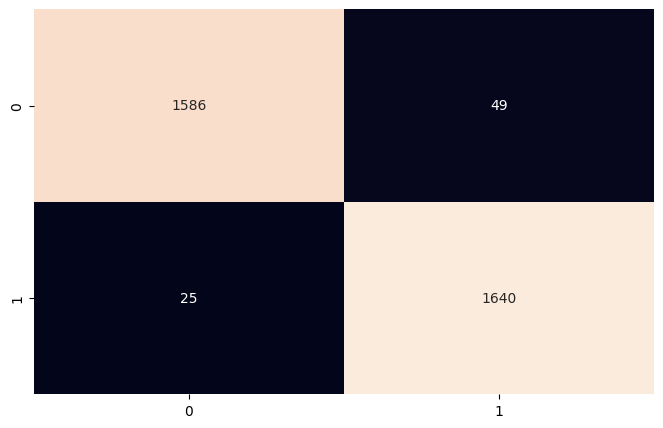

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))
print(classification_report(y_test, y_pred))
cf_matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize = (8, 5))
sns.heatmap(cf_matrix, annot = True, cbar = False, fmt = "g")
plt.show()